# Model evaluation on test datasets

In this notebook, we demonstrate how to load and evaluate a trained model from the [model training demo](prd_demo_fraction_model_spice.ipynb). Once the pretrained model is loaded, we load in test scenario datasets and pass through the ML model for inference before calculating and visualising performance metrics of the resulting predictions. 

Firstly, we import relevant libraries

In [1]:
import pathlib
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import mlflow

In [3]:
import prd_pipeline

AzureML libraries not found, using local execution functions.


## Set up MLFlow and load pretrained model

In [4]:
tracking_uri = mlflow.get_tracking_uri()
print("Current tracking uri: {}".format(tracking_uri))

Current tracking uri: file:///net/home/h02/hbrown/code/git/precip_rediagnosis/model_pipeline/mlruns


The run_id is required to load the pretrained model from MLFlow. The run_id for each experiment run tracked using MLFlow can be found via the MLFlow user interface (launched by running ```mlflow ui``` in the command line). Once the run_id is know, we can easily load in models trained for previous experiments for inference and evaluation.

In [5]:
run_id = '7ed769ea194f48288c9a2c6a80985971'# 'a3360154e69047af8933fe4c44974f40'
trained_model = mlflow.keras.load_model(f'runs:/{run_id}/model')

2022-12-19 13:15:51.354078: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Test data set up and loading

The data set up here should be the same as the set up from model training, including the same set of precipitation intensity bands and the same model input features. Selecting the target parameter (data from radar) and NWP comparison datasets, means that we once we have run inference and have some ML predictions we can compare how these predictions are performing compared to our truth dataset, as well as comparing ML prediction performance to NWP predictions. 

In [6]:
bands = {
    '0.0':[0, 0.01],
    '0.25':[0.01, 0.5], 
    '2.5': [0.5, 4], 
    '7.0':[4, 10], 
    '10.0':[10,220]
}

In [7]:
intensity_bands = [f'{lower_bound}mm-{upper_bound}mm' for lower_bound, upper_bound in bands.values()]

In [8]:
intensity_band_template = '{source}_fraction_in_band_instant_{band_centre}'

In [9]:
target_parameter = [intensity_band_template.format(source='radar', band_centre=threshold) for threshold in bands.keys()]
nwp_comparison = [intensity_band_template.format(source='mogrepsg', band_centre=threshold) for threshold in bands.keys()]

profile_features = ['air_temperature', 'relative_humidity',  'wind_speed', 'wind_from_direction', 'cloud_volume_fraction'] #air_pressure',
single_lvl_features = []#['surface_altitude']#'thickness_of_rainfall_amount', 'surface_altitude', 'air_pressure_at_sea_level', 'cloud_area_fraction'

In [10]:
feature_dict = {
    'profile': profile_features,
    'single_level': single_lvl_features,
    'target': target_parameter,
    'nwp': nwp_comparison, 
    'metadata': ['time', 'realization', 'latitude', 'longitude']
} 

In [11]:
data_dims_dict = {
    'nprof_features': len(profile_features), 
    'nheights': 33, 
    'nsinglvl_features': len(single_lvl_features), 
    'nbands': len(bands)
}

We select the filepath of the test scenario dataset. Here, test_scenario can currently be set to either 'storm_ciara' or 'storm_eunice_franklin' (but can be set to any event name that has been left out of the model training dataset).

In [12]:
dataset_dir = '/project/informatics_lab/precip_rediagnosis/train_202212'
dataset_dir = pathlib.Path(dataset_dir)

prd_path_list = [p1 for p1 in dataset_dir.rglob(f'{prd_pipeline.MERGED_PREFIX}*{prd_pipeline.CSV_FILE_SUFFIX}')]

In [13]:
test_scenario_name = 'storm_eunice_franklin' 
test_scenario_filepath = [event for event in prd_path_list if test_scenario_name in str(event)][0]
test_scenario_filepath

PosixPath('/project/informatics_lab/precip_rediagnosis/train_202212/2022_storm_eunice_franklin/prd_merged_20220218T1200Z_20220221T1200Z.csv')

In [14]:
test_scenario = pd.read_csv(test_scenario_filepath)

## Data prep on test scenario dataset

As we want the test data to have the same format as the data used to train our model, we have to apply the same preprocessing to our test datasets. The preprocess_test function applies steps such as scaling and reshaping of the model input data, this function can either take a filepath (PosixPath format) or a pandas DataFrame. 

In [15]:
data_splits_test = prd_pipeline.preprocess_test_data(test_scenario, feature_dict, data_dims_dict)

Once the data is loaded and preprocessed we can use it for model inference. 

Once we have the ML predictions, we create an evaluation dataframe that contains radar, NWP and ML predicted fractions, as well as associated metadata (time, location, ens members), to ease subsequent analyses. 

In [16]:
ypred_test = trained_model.predict(data_splits_test['X_test'])
pred_column_names = [intensity_band_template.format(source='ml', band_centre=threshold) for threshold in bands.keys()]
ypred_test_df = pd.DataFrame(ypred_test, columns=pred_column_names)

## Fractional skill score

The fractional skill score (FSS) is a verification metric often used to assess the performance of a probabilistic precipitation forecast. It allows comparison of predicted precipitation values to precipitions observed by radar, our source of truth.

Note: Fractional skill scores are calculated on probabilities of exceeding thresholds, so we convert our discrete probability distributions (i.e. fractions in different intensity bands) to a cumulative distribution function. This is done within the calculate metric function if 'fss' is provided for the metric argument. 

Firstly we calculate the FSS for our entire test scenario dataset. 

FSS where each ML prediction for different NWP ensemble member treated as deterministic 

In [17]:
fss_all = prd_pipeline.calculate_metric(test_scenario, trained_model, feature_dict, data_dims_dict, metric='fss')

In [18]:
fss_all.round(4)

ml_fss_0.0      0.6585
ml_fss_0.25     0.5160
ml_fss_2.5      0.1762
ml_fss_7.0      0.0340
ml_fss_10.0     0.0000
nwp_fss_0.0     0.7102
nwp_fss_0.25    0.6096
nwp_fss_2.5     0.0987
nwp_fss_7.0     0.0044
nwp_fss_10.0    0.1211
dtype: float64

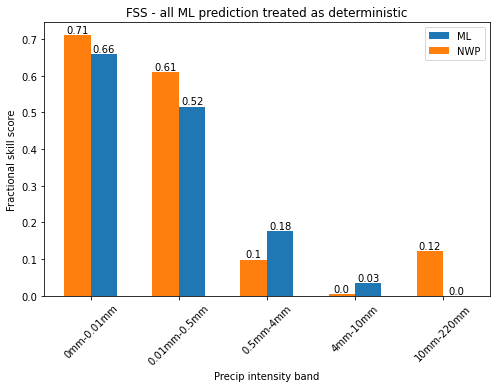

In [19]:
plot_annotations = {
    'title': 'FSS - all ML prediction treated as deterministic',
    'xlabel': 'Precip intensity band', 
    'ylabel': 'Fractional skill score'
}
fig, ax = prd_pipeline.metric_barchart(fss_all[:5], fss_all[5:], intensity_bands, plot_annotations)
plt.show()

FSS where the ML predictions are the mean of the set of ML prediction from NWP ensemble members

In [20]:
grouped = test_scenario.groupby(['time', 'latitude', 'longitude']).agg('mean')
fss_ens_mean = prd_pipeline.calculate_metric(grouped.reset_index(), trained_model, feature_dict, data_dims_dict, metric='fss')

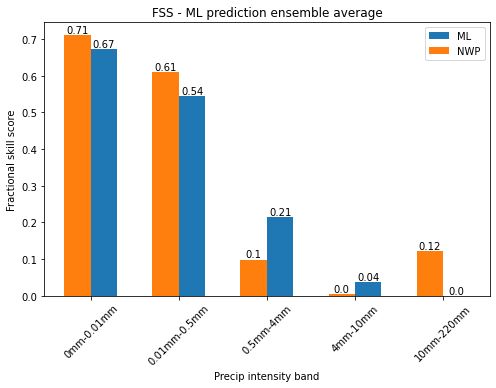

In [21]:
plot_annotations = {
    'title': 'FSS - ML prediction ensemble average',
    'xlabel': 'Precip intensity band', 
    'ylabel': 'Fractional skill score'
}
fig, ax = prd_pipeline.metric_barchart(fss_ens_mean[:5], fss_ens_mean[5:], intensity_bands, plot_annotations)
plt.show()

FSS where the ML predictions are only using control member of the NWP ensemble

In [22]:
fss_control = prd_pipeline.calculate_metric(test_scenario[test_scenario['realization']==0], trained_model, feature_dict, data_dims_dict, metric='fss').round(4)

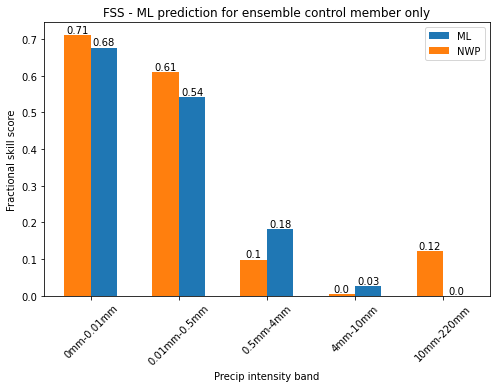

In [23]:
plot_annotations = {
    'title': 'FSS - ML prediction for ensemble control member only',
    'xlabel': 'Precip intensity band', 
    'ylabel': 'Fractional skill score'
}
fig, ax = prd_pipeline.metric_barchart(fss_control[:5], fss_control[5:], intensity_bands, plot_annotations)

plt.show()

### Plot fractional skill score for each grid cell on map

To understand whether the performance of the the ML model is consistant across the domain, the test scenario dataset is grouped by latitude and longitude, allowing the FSS for each grid cell to be calculated. This information is then presented on a map comparing the FSS for NWP and ML predicted values. 

Again, there is the options to either treat each ensemble member as a deterministics forecast, to average the the ML predictions from each ensemble member or to only use the ML prediction based on the NWP control forecast.

In [24]:
ml_prediction_acc = 'deterministic'

In [25]:
if ml_prediction_acc == 'deterministic':
    fss_grid = test_scenario.groupby(['latitude', 'longitude']).apply(
        lambda x: prd_pipeline.calculate_metric(x, trained_model, feature_dict, data_dims_dict, metric='fss'))
if ml_prediction_acc == 'average':
    grid_grouped_df = test_scenario.groupby(['time', 'latitude', 'longitude']).agg('mean').reset_index()
    fss_grid = grid_grouped_df.groupby(['latitude', 'longitude']).apply(
        lambda x: prd_pipeline.calculate_metric(x, trained_model, feature_dict, data_dims_dict, metric='fss'))
if ml_prediction_acc == 'control':
    fss_grid = test_scenario[test_scenario.realization==0].groupby(['latitude', 'longitude']).apply(
        lambda x: prd_pipeline.calculate_metric(x, trained_model, feature_dict, data_dims_dict, metric='fss'))

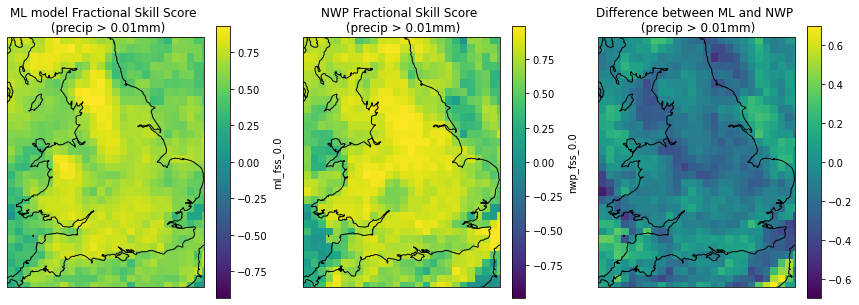

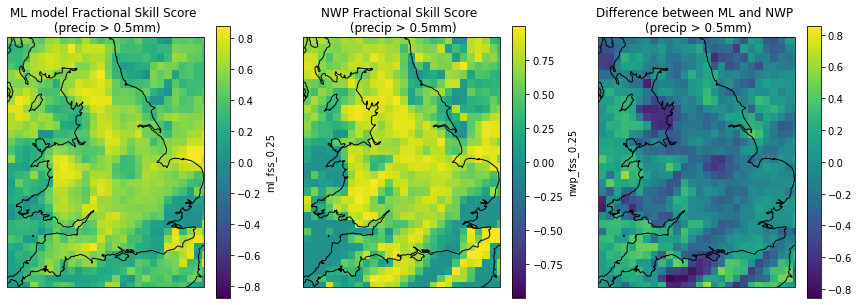

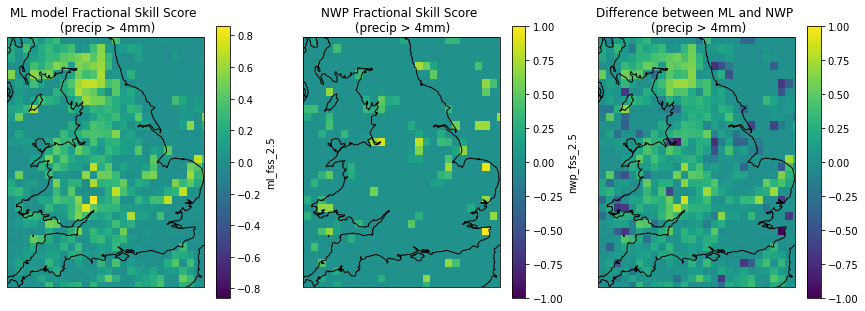

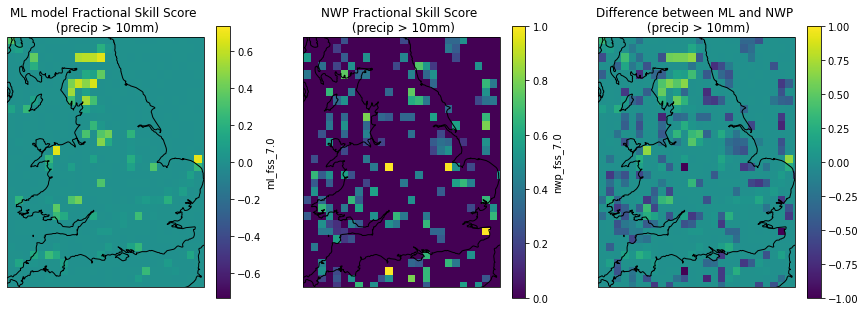

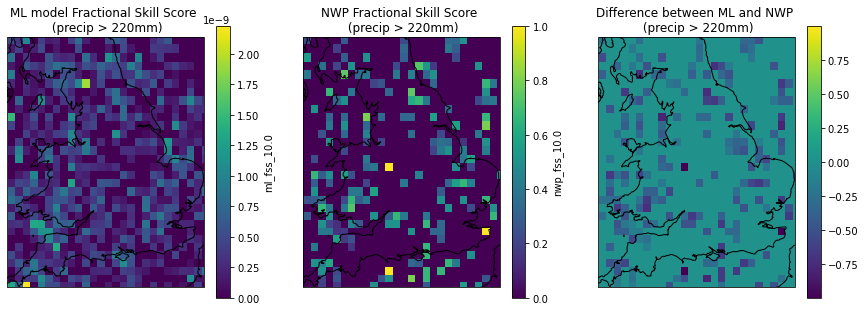

In [26]:
for intensity_band_centre, (lower_bound, upper_bound) in bands.items():
    fig, ax = prd_pipeline.plot_metric_on_map(
        fss_grid.fillna(0).to_xarray(), threshold=intensity_band_centre, metric='fss')
    
    ax[0].set_title(f'ML model Fractional Skill Score \n (precip > {upper_bound}mm)')
    ax[1].set_title(f'NWP Fractional Skill Score \n (precip > {upper_bound}mm)')
    ax[2].set_title(f'Difference between ML and NWP \n (precip > {upper_bound}mm)')
    plt.show()

Now we have a grid of FSS values, we can also calculate the domain average FSS. 

In [27]:
fss_grid_avg = fss_grid.dropna().mean()

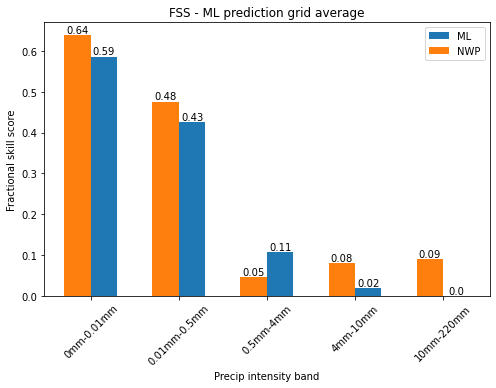

In [28]:
plot_annotations = {
    'title': 'FSS - ML prediction grid average',
    'xlabel': 'Precip intensity band', 
    'ylabel': 'Fractional skill score'
}
fig, ax = prd_pipeline.metric_barchart(fss_grid_avg[:5], fss_grid_avg[5:], intensity_bands, plot_annotations)
plt.show()

## Frequency bias

The frequency bias is is the ratio between predicted fractions and observed fractions in each precipitation intensity band. This allows us to understand when the model is under or over predicting the fractions in each intensity band. 

- freq_bias = 0 indicates fx=0 and obs>0 
- 0 < freq_bias < 1 indicates fx < obs
- freq_bias = 1 (or close) fx == obs (or almost)
- freq_bias > 1 indicates fx > obs
- freq_bias = inf when obs=0

A very large frequency bias indicates fx >> obs (or very small obs value)


In [29]:
freq_bias_all = prd_pipeline.calculate_metric(test_scenario, trained_model, feature_dict, data_dims_dict, metric='freq_bias')

In [30]:
freq_bias_tmp = freq_bias_all - 1
freq_bias_tmp = np.where(freq_bias_tmp < 0, 1/freq_bias_tmp, freq_bias_tmp)

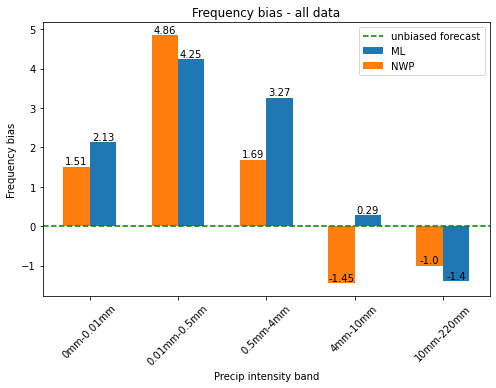

In [31]:
plot_annotations = {
    'title': 'Frequency bias - all data',
    'xlabel': 'Precip intensity band', 
    'ylabel': 'Frequency bias'
}
fig, ax = prd_pipeline.metric_barchart(freq_bias_tmp[:5], freq_bias_tmp[5:], intensity_bands, plot_annotations)
ax.axhline(0, c='green', ls='--', label='unbiased forecast')
plt.legend()
plt.show()
# plt.savefig(f'{test_scenario_name}_freq_bias_all_samples.png')

### Plot frequency bias for each grid cell on a map

As with FSS, we plot the frequency bias on a map to understand any spatial distribution of model performance. 

Note: In the plots for ML and NWP frequency bias, we use a log scale. Also NaN values (where obs=0) are replaced with a fill value of 10000 and show up as yellow in the plot.


In [32]:
if ml_prediction_acc == 'deterministic':
    freq_bias_grid = test_scenario.groupby(['latitude', 'longitude']).apply(
        lambda x: prd_pipeline.calculate_metric(x, trained_model, feature_dict, data_dims_dict, metric='freq_bias'))
if ml_prediction_acc == 'average':
    grid_grouped_df = test_scenario.groupby(['time', 'latitude', 'longitude']).agg('mean').reset_index()
    freq_bias_grid = grid_grouped_df.groupby(['latitude', 'longitude']).apply(
        lambda x: prd_pipeline.calculate_metric(x, trained_model, feature_dict, data_dims_dict, metric='freq_bias'))
if ml_prediction_acc == 'control':
    freq_bias_grid = test_scenario[test_scenario.realization==0].groupby(['latitude', 'longitude']).apply(
        lambda x: prd_pipeline.calculate_metric(x, trained_model, feature_dict, data_dims_dict, metric='freq_bias'))

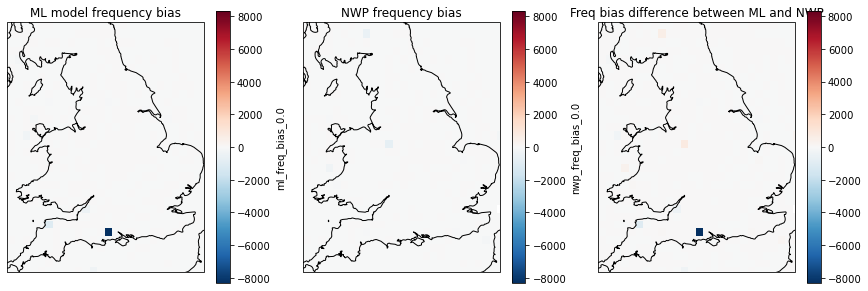

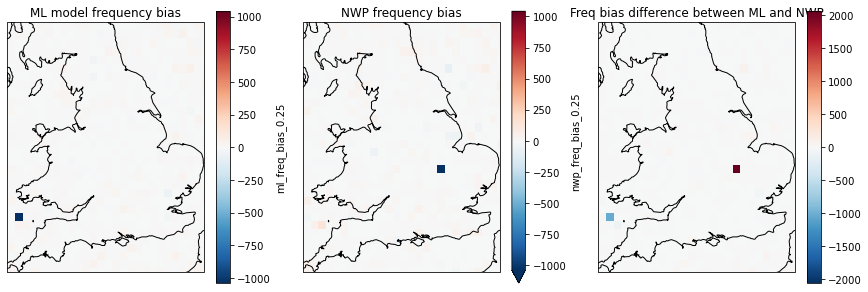

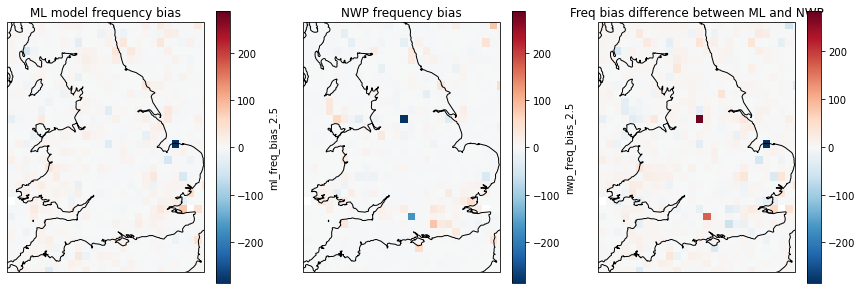

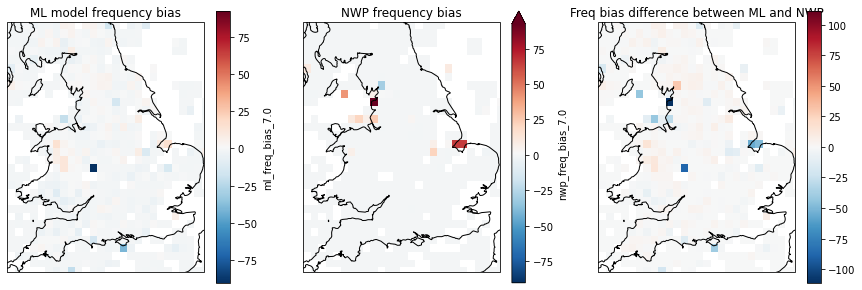

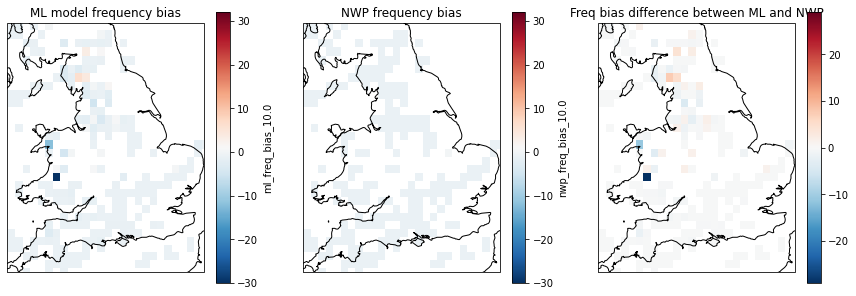

In [33]:
freq_bias_grid = freq_bias_grid - 1
freq_bias_grid = freq_bias_grid.where(freq_bias_grid > 0, 1/freq_bias_grid)

for band in bands.keys():
    threshold=band
    fig, ax = prd_pipeline.plot_metric_on_map(
        freq_bias_grid.to_xarray(), threshold, metric='freq_bias')
    
    ax[0].set_title(f'ML model frequency bias')
    ax[1].set_title(f'NWP frequency bias')
    ax[2].set_title(f'Freq bias difference between ML and NWP')
    # plt.savefig(f'{test_scenario_name}_map_of_freq_bias_{band}.png')
    plt.show()

Now we have a grid of frequency bias values, we can also calculate the domain average frequency bias. 

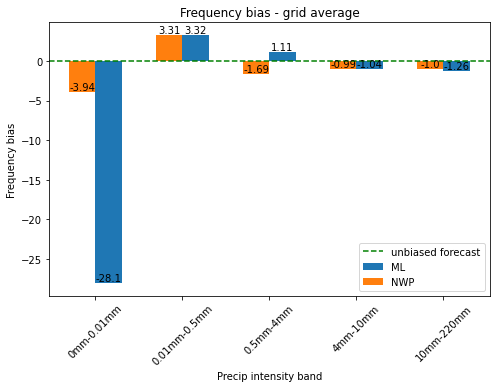

In [34]:
freq_bias_grid_avg = freq_bias_grid.dropna().mean()

plot_annotations = {
    'title': 'Frequency bias - grid average',
    'xlabel': 'Precip intensity band', 
    'ylabel': 'Frequency bias'
}
fig, ax = prd_pipeline.metric_barchart(freq_bias_grid_avg[:5], freq_bias_grid_avg[5:], intensity_bands, plot_annotations)
ax.axhline(0, c='green', ls='--', label='unbiased forecast')
plt.legend()
plt.show()
# plt.savefig(f'{test_scenario_name}_grid_cell_freq_bias_average.png')